# Reinforcement Learning

## Policy Gradient

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import choice, uniform
from collections import defaultdict

In [2]:
class Environment:
    def __init__(self, L=10, left_reward=0, right_reward=20):
        self.states = np.arange(-L-1, L+2)
        self.terminal = [min(self.states), max(self.states)]
        self.rewards = [left_reward, right_reward]
    
    def reset(self):
        self.state = choice(self.states[1:-1])
        return self.state
    
    def step(self, a):
        # Check if environment is initialized
        if not hasattr(self, 'state'):
            raise RuntimeError("Environment.reset must be called before calling Environment.step")
        # Check if the action is valid
        if a not in ['L', 'R']:
            raise ValueError("The action must be either 'L' or 'R'")
        
        state = self.state + (-1 if a == 'L' else 1)
        terminal = state in self.terminal
        reward = -1 if not terminal else (self.rewards[0] if state == min(self.states) else self.rewards[1])
        self.state = state
        # Delete state to avoid undefined behavior for subsequent step method calls
        if terminal: delattr(self, 'state')
        return state, reward, terminal

In [3]:
class Policy:
    def __init__(self, theta=0, beta=0.5):
        self.ACTIONS = ['L', 'R']
        self.theta = theta
        self.beta = beta
    
    def sample_action(self, state):
        lp, _ = self.get_probs(state)
        # With probability lp select action 0 ('L')
        return self.ACTIONS[int(lp < uniform(0, 1))]
    
    def get_probs(self, state):
        p = (1+np.exp(-self.beta*(state-self.theta)))**-1
        # For completeness, returns probs for both actions
        return 1-p, p

In [4]:
def simulate_episode(env, policy, return_full_episode=False):
    states, actions, rewards = list(), list(), list()
    s = env.reset()
    done = False
    while not done:
        states.append(s)
        a = policy.sample_action(s)
        s, r, done = env.step(a)
        actions.append(a)
        rewards.append(r)
    return (states, actions, rewards) if return_full_episode else sum(rewards)

#### Question 1

In [5]:
env = Environment(L=20)
thetas = np.linspace(-20, 20, 100)
rewards = {theta: list() for theta in thetas}
n = 1000

for theta in thetas:
    policy = Policy(theta=theta)
    for _ in range(n):
        rewards[theta].append(simulate_episode(env, policy))
rewards = pd.DataFrame(rewards)

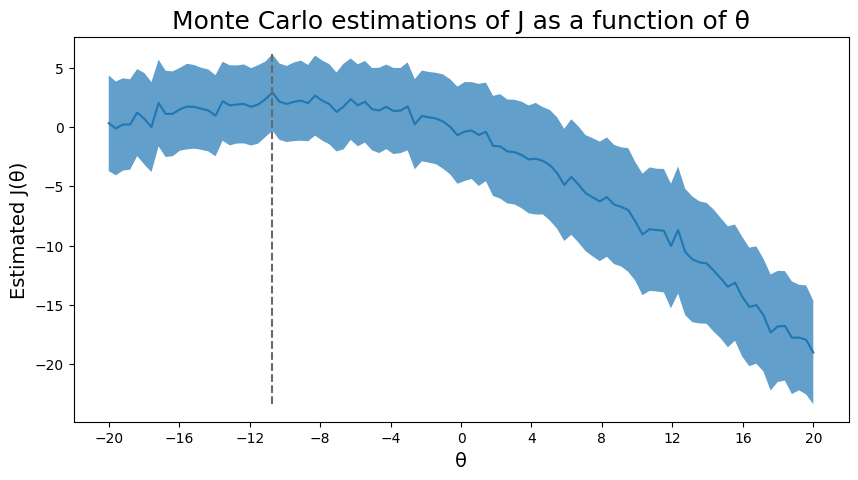

In [6]:
plt.figure(figsize=(10,5))
plt.plot(rewards.columns, rewards.mean())
plt.fill_between(rewards.columns, rewards.mean() + rewards.std()/3, rewards.mean() - rewards.std()/3, alpha=0.7)
plt.vlines(rewards.mean().idxmax(), (rewards.mean() - rewards.std()/3).min(),
           (rewards.mean() + rewards.std()/3).max(), color='dimgray', linestyles='--')
plt.xlabel("θ", fontsize=14)
plt.xticks(list(range(-20, 21, 4)))# + [rewards.mean().idxmax()])
plt.ylabel("Estimated J(θ)", fontsize=14)
plt.title("Monte Carlo estimations of J as a function of θ", fontsize=18)
# plt.savefig("figures/MC_estimations.png")
plt.show()

In [7]:
rewards.mean().idxmax()

-10.707070707070708

#### Question 2

In [8]:
k = 100
thetas = np.linspace(min(env.states) + 1, max(env.states) - 1, k)
policy_diff = lambda: simulate_episode(env, p1) - simulate_episode(env, p2)
h, n = 0.5, 1000
derivatives = list()

for theta in thetas:
    p1, p2 = Policy(theta=theta + h), Policy(theta=theta)
    derivatives.append(sum([policy_diff() / h for _ in range(n)]) / n)

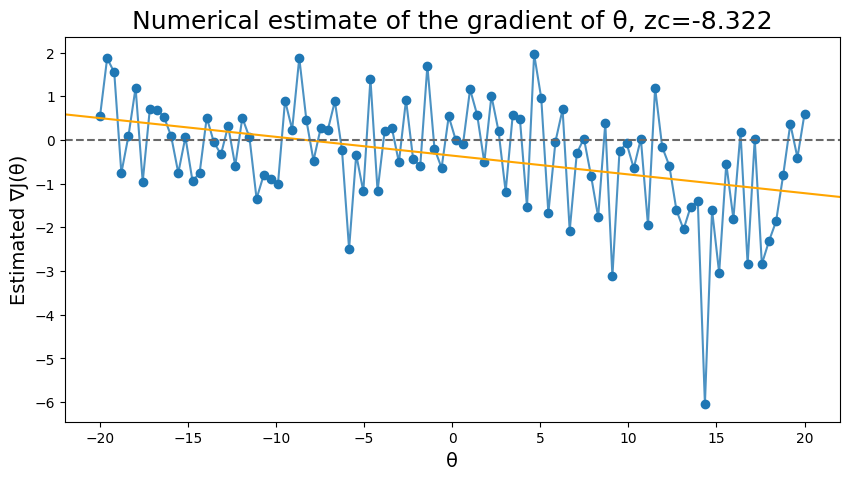

In [9]:
intersect, slope = np.linalg.lstsq(np.vstack([np.ones(k), thetas]).T,
                                   np.asarray(derivatives).reshape(-1, 1), rcond=None)[0]

plt.figure(figsize=(10,5))
plt.plot(thetas, derivatives, alpha=0.8)
plt.scatter(thetas, derivatives)
plt.axline([0, intersect[0]], slope=slope[0], c='orange')
plt.axline([0, 0], slope=0, c='dimgray', linestyle='--')
plt.title(f"Numerical estimate of the gradient of θ, zc={-intersect[0]/slope[0]:.03f}", fontsize=18)
plt.ylabel("Estimated ∇J(θ)", fontsize=14)
plt.xlabel("θ", fontsize=14)
# plt.savefig("figures/numerical.png")
plt.show()

#### Question 3

In [10]:
def compute_grad(policy, episode):    
    grad, R = 0, 0
    for s, a, r in reversed(list(zip(*episode))):
        R += r
        grad += R * policy.beta * (policy.get_probs(s)[1] - (1 if a == 'R' else 0))
    return grad

In [11]:
# Gradient ascent playground to test if the algorithm works as expected
L = 20
left_reward = 0
right_reward = 20
theta0 = 0
lr = 1e-2
n_episodes = 50000

env = Environment(L=L, left_reward=left_reward, right_reward=right_reward)
policy = Policy(theta=theta0)
for _ in range(n_episodes):
    grad = compute_grad(policy, simulate_episode(env, policy, return_full_episode=True))
    policy.theta += lr * grad
print(policy.theta)

-10.41868103581859


In [12]:
# Gradient ascent playground to test if the algorithm works as expected
k = 50
thetas = np.linspace(-L, L, k)
n_episodes = 1000
grads = list()

env = Environment(L)
for theta in thetas:
    policy = Policy(theta=theta)
    grad = sum([compute_grad(policy, simulate_episode(env, policy, return_full_episode=True))
            for i in range(n_episodes)])/n_episodes
    grads.append(grad)

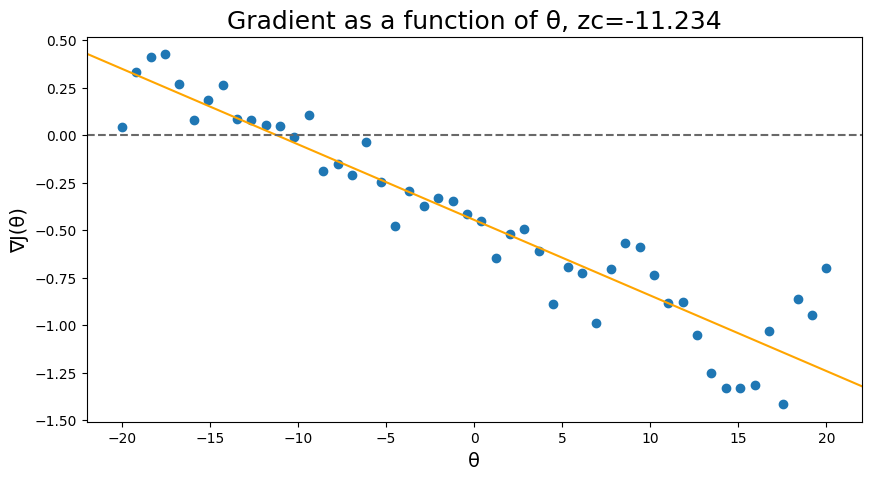

In [13]:
intersect, slope = np.linalg.lstsq(np.vstack([np.ones(k), thetas]).T,
                                   np.asarray(grads).reshape(-1, 1), rcond=None)[0]

plt.figure(figsize=(10,5))
plt.scatter(thetas, grads)
plt.axline([0, intersect[0]], slope=slope[0], c='orange')
plt.axline([0, 0], slope=0, c='dimgray', linestyle='--')
plt.title(f"Gradient as a function of θ, zc={-intersect[0]/slope[0]:.03f}", fontsize=18)
plt.ylabel("∇J(θ)", fontsize=14)
plt.xlabel("θ", fontsize=14)
# plt.savefig("figures/gradient.png")
plt.show()

# Advantage Actor-Critic

In [14]:
def MC_prediction(V, states, rewards, counts=None, lr=0.01):
    R = 0
    for i, (s, r) in enumerate(zip(reversed(states), reversed(rewards))):
        R += r
        # Only consider first visits
        if s not in states[:-i-1]:
            if counts is not None:
                counts[s] += 1
            V[s] += (R-V[s]) * (counts[s]**-1 if counts is not None else lr)

def evaluate(env, policy, V=None, counts=None, n_episodes=100):
    if V is None:
        V = defaultdict(float)
    if counts is None:
        counts = defaultdict(float)
    for _ in range(n_episodes):
        states, _, rewards = simulate_episode(env, policy, return_full_episode=True)
        MC_prediction(V, states, rewards, counts=counts)
    return pd.Series(V).sort_index()

def run_evaluations(env, theta, n=10):
    df = pd.DataFrame()
    policy = Policy(theta=theta)
    for _ in range(n):
        df = pd.concat([df, evaluate(env, policy)], axis=1)
    return df

def plot_from_df(df, theta):
    df.mean(axis=1).plot(label=f"Initial θ={theta}")
    plt.fill_between(env.states[1:-1], df.mean(axis=1) + df.std(axis=1),
                     df.mean(axis=1) - df.std(axis=1), alpha=0.6)

def compute_grad(policy, episode, V):    
    grad, R = 0, 0
    for s, a, r, ns in zip(*episode, episode[0][1:] + [np.infty]):
        grad += (V[ns] - V[s] + r) * policy.beta * (policy.get_probs(s)[1] - (1 if a == 'R' else 0))
    return grad

def fit(env, policy, V, n_episodes=7000, lr=0.1):
    thetas = [policy.theta]
    for _ in range(n_episodes):
        episode = simulate_episode(env, policy, return_full_episode=True)
        MC_prediction(V, episode[0], episode[2])
        grad = compute_grad(policy, episode, V)
        policy.theta += lr * grad
        thetas.append(policy.theta)
    return thetas

def create_fits(env, n=10):
    df = pd.DataFrame()
    thetas = list()
    for _ in range(n):
        V = defaultdict(float)
        policy = Policy(theta=theta)
        evaluate(env, policy, V)
        thetas.append(fit(env, policy, V))
        df = pd.concat([df, pd.Series(V).sort_index()], axis=1)
    return df, thetas

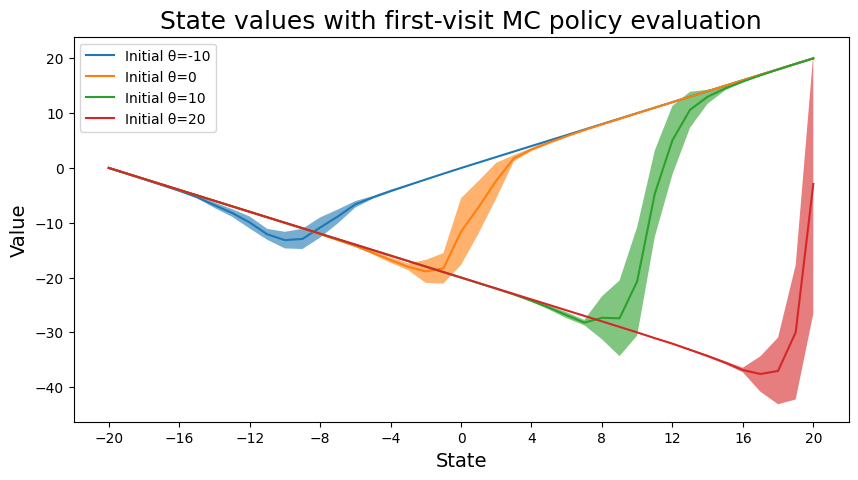

In [15]:
plt.figure(figsize=(10,5))
env = Environment(L=20)

for theta in [-10, 0, 10, 20]:
    df = run_evaluations(env, theta)
    plot_from_df(df, theta)

plt.xticks(env.states[1:-1:4])
plt.title("State values with first-visit MC policy evaluation", fontsize=18)
plt.legend()
plt.xlabel("State", fontsize=14)
plt.ylabel("Value", fontsize=14)
# plt.savefig("figures/value_pre.png")
plt.show()

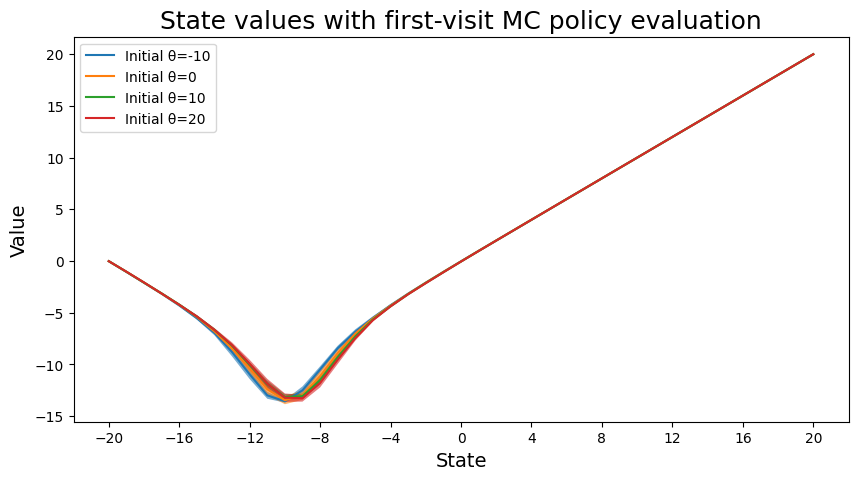

In [16]:
plt.figure(figsize=(10,5))
thetas = list()
for theta in [-10, 0, 10, 20]:
    df, t = create_fits(env)
    thetas.append(t)
    plot_from_df(df.iloc[:-1], theta)

plt.xticks(env.states[1:-1:4])
plt.title("State values with first-visit MC policy evaluation", fontsize=18)
plt.legend()
plt.xlabel("State", fontsize=14)
plt.ylabel("Value", fontsize=14)
# plt.savefig("figures/value_post.png")
plt.show()

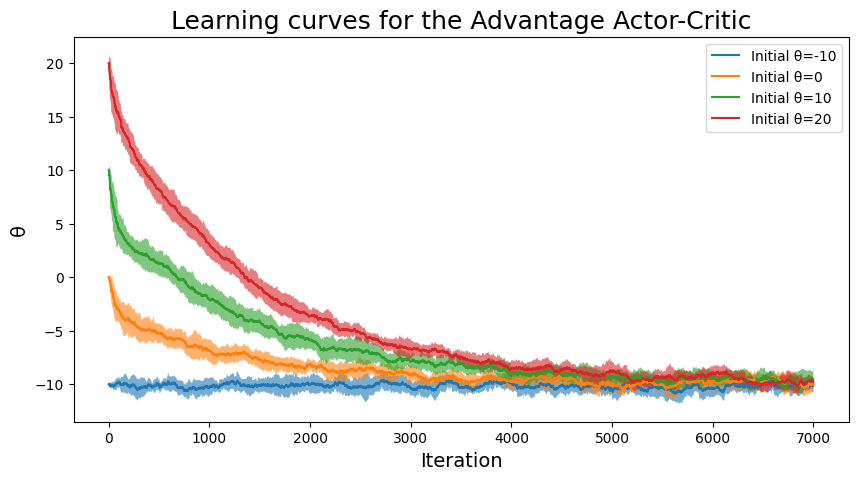

In [17]:
plt.figure(figsize=(10,5))
for t in np.asarray(thetas):
    plt.plot(t.mean(axis=0), label=f"Initial θ={t[0][0]:.0f}")
    plt.fill_between(range(t.shape[-1]), t.mean(axis=0) + t.std(axis=0),
                     t.mean(axis=0) - t.std(axis=0), alpha=0.6)

plt.title("Learning curves for the Advantage Actor-Critic", fontsize=18)
plt.legend()
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("θ", fontsize=14)
# plt.savefig("figures/learning.png")
plt.show()